# Content and Objective

+ Show result of "temperature estimation"

In this example we take a look at the estimation of an unknown parameter, in this case the temperature. Then we try to get a better understanding of the boxplot used in descriptive statistics.

We consider the following modell: We want to estimate an unknown but deterministic temperature $\theta$. We get our iid (identical and indedependently distributed) observations from a measurement, where the temperature is superimposed with some AWGN:

$$x_i=\theta + n_i\quad \text{ with } n_i\sim \mathcal{N}(0,\sigma^2) , \quad i\in[1:N]$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

rng=np.random.default_rng()

In [2]:
def generate_iid_observation(temperature,observation_length,std_deviation):

    observation_array = np.repeat( temperature, observation_length)+std_deviation*rng.normal(size=observation_length)
    return observation_array


In [3]:
def plot_boxplot_of_measurement( temperature, observation_length, std_deviation):
    data = generate_iid_observation( temperature, observation_length, std_deviation)
    fig = plt.figure(figsize=(10, 7.5))
    plt.title('Boxplot of temperature measurement')
    plt.boxplot(data)

In [4]:
w = widgets.interact(plot_boxplot_of_measurement, temperature=widgets.IntSlider(min=0, max=100),
                     observation_length=widgets.IntSlider(min=1, max=int(1e3),value=10),
                     std_deviation=widgets.FloatSlider(min=0, max=50,value=2))


interactive(children=(IntSlider(value=0, description='temperature'), IntSlider(value=10, description='observat…

### Now we can go through some of the used parameters within the boxplot to get a better understanding of the statistics.



In [5]:
observation = generate_iid_observation( temperature= 100,observation_length=40, std_deviation=2)

Let's calculate the arithmetic mean:
$$\bar{x}=\frac{1}{n}\sum_{i=1}^{N}x_i$$

and the median. The median of a set of observations is the value, such that half of the oberservation take on higher values and the other half take on lower values. For the calculation we first order the observations in ascending order of their values: $\mathbf{x}=(x_1,\dots ,x_N)$. 
Now, depending whether the obersation length $N$ is even or not even, the median can be determined as follows:
$$x_{1/2}=\begin{cases} x_{(\frac{N+1}{2})}, & N \text{ is odd}\\
 \frac{1}{2}\left( x_{(\frac{N}{2})}+x_{(\frac{N}{2}+1)}\right),& N \text{ is even}\end{cases}.$$


The generalization of the median are quantiles with $p\in(0,1)$:
$$x_{p}=\begin{cases} x_{(\lfloor Np+1\rfloor)}, & Np \notin \mathbb{ N}\\
 \frac{1}{2}\left( x_{(Np)}+x_{(Np+1)}\right),&Np \in \mathbb{ N}\end{cases}.$$





 We compare the methods provided by numpy with own implementations:

In [6]:
def arithmetic_mean(data):
    return np.sum(data) / len(data)

def calc_median(data): # CARE:  In python we start indexing with 0! Therefore we get slightly different results
    N = len(data)
    data = np.sort(data) #sorts array in ascending order
    if( N%2 == 0):
        return 1/2*(data[int(N/2 -1 )]+data[int(N/2)])
    else:
        return data[int((N+1)/2 -1)]

def p_quantil(data, p):
    N = len(data)
    data = np.sort(data) #sorts array in ascending order
    if(N*p != int(N*p)):
        return data[int(N*p)]
    else:
        return 1/2*(data[int(N*p)-1]+data[int(N*p)]) ##HIER NOCH EIN FEHLER?!

In [7]:
x_bar_np=np.average(observation)
x_bar=arithmetic_mean(observation)
print("Arithmetic Mean: Numpy: ",x_bar_np, "Own: ", x_bar)

x_12_np=np.median(observation)
x_12=calc_median(observation)

print("Median: Numpy: ",x_12_np, "Own: ", x_12)


#p=3/4 Quantil
p=0.75

x_34_np=np.quantile(observation,p,interpolation='midpoint')
x_34=p_quantil(observation,p)

print("p="+str(p) +" Quantile: : Numpy: ",x_34_np, "Own: ", x_34)


Arithmetic Mean: Numpy:  99.37136215386961 Own:  99.37136215386961
Median: Numpy:  99.22240016500297 Own:  99.22240016500297
p=0.75 Quantile: : Numpy:  100.48854490607638 Own:  100.48854490607638


In [8]:
quartilsabstand=p_quantil(observation,0.75)-p_quantil(observation,0.25)

 Empirical variance: The factor $\frac{1}{n-1}$ is to be used, such that the estimator is unbiased in many cases (e.g deterministic paramter with AWGN), if the mean itself was estimated using the arithmetic mean: 
$$s^2=\frac{1}{n-1}\sum_{i=1}^n(x_i-\bar{x})^2$$

In case that the true expected value $\mathbb{E}(X)=\mu_x$ is known, then the following estimator is unbiased:
$$s^2=\frac{1}{n}\sum_{i=1}^n(x_i-\mu_x)^2$$

This can be explained as follows: By calculating the arithmetic mean one degree of freedom is alread used. This means that, if $\bar{x}$ is known, and all but the last observation $(x_1,\dots,x_{n-1})$ are known, then the last observation $x_n=n\cdot \bar{x}-\sum_i^{n-1}x_i$ can be calculated.



In [9]:
def empirical_variance(data):
    n=len(data)
    x_bar=np.average(data)
    data-=np.ones(n)*x_bar
    data=np.power(data,2)

    return data.sum()/(n-1)


In [10]:
var_np=np.var(observation,ddof=1) #ddof=1 --> unbiased estimator

var=empirical_variance(observation)


print("Empirical Variance: : Numpy: ",var_np, "Own: ", var)

Empirical Variance: : Numpy:  3.6200177325361156 Own:  3.6200177325361156


## Now an example that illustrates the importance of the correct scaling. This is especially true, if the number of observations is small!

In [11]:

temperature=100
unknown_variance=16
std_deviation=np.sqrt(unknown_variance)
number_observations=3 # Small number to show the effect as for large n 1/n approx 1/n-1

#We know calculate the estimate of the estimator
size_ensemble=int(1e1)
estimated_var_unb=np.zeros(size_ensemble)
estimated_var_bia=np.zeros(size_ensemble)

for i in range(size_ensemble):
    observation_realization=generate_iid_observation(temperature,number_observations,std_deviation)
    estimated_var_unb[i]=np.var(observation_realization,ddof=1)
    estimated_var_bia[i]=np.var(observation_realization,ddof=0)
    

print("Estimated var: biased:",np.average(estimated_var_bia)," unbiased: ", np.average(estimated_var_unb))

Estimated var: biased: 6.270316195225861  unbiased:  9.40547429283879


# Now we want to gather all results and compare it to the box plot.

Be carefull with documentations. E.g it is not immediately apparent, that plt.boxplot uses interpolation to determine the 3/4 and 1/4 percentile!



In [12]:
observation=generate_iid_observation(temperature= 100,observation_length=20, std_deviation=15)

[ 77.29477893  82.25859713  85.22611929  89.04127644  90.70710192
  94.17425244  96.8272008   97.59391101  98.28122273  98.62654621
  99.36241932 101.04720718 101.77049801 112.27728703 112.6800597
 114.83367517 115.68637924 117.41273495 122.0653639  136.19108645]


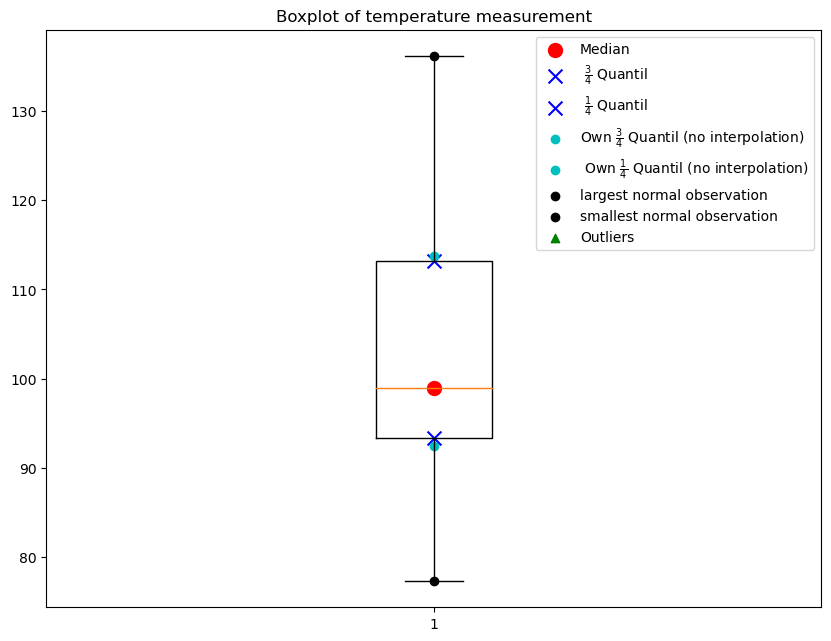

In [13]:


# sort simplifies the search for the smallest and largest 'normal' observation
observation = np.sort(observation)

print(observation)
x_12 = calc_median(observation)  # own implementation

# Percentiles from np! according to the documentation they use some interpolation, this lead to different within the boxplot
upper_quantil = np.quantile(observation, 0.75)
lower_quantil = np.quantile(observation, 0.25)

# Own percentile implementation that doesn't use interpolation. Same results as numpys implementation if method='midpoint' is included in np.quantile
upper_quantil_own = p_quantil(observation, 0.75)
lower_quantil_own = p_quantil(observation, 0.25)


# The largest 'normal' observation is the largest OBSERVATION (thus it is itself an element in the observation array) below 3/4Q+ 3/2 (3/4Q-1/4Q)
largest_normal_observation = upper_quantil+1.5*(upper_quantil-lower_quantil)
# Take the largest observation that is below the defined threshold
largest_normal_observation = observation[observation <
                                         largest_normal_observation][-1]

# Here vice versa: Smallest observation above 3/4Q - 3/2 (3/4Q-1/4Q)
lowest_normal_observation = lower_quantil-1.5*(upper_quantil-lower_quantil)
# Take smallest observation that is above the threshold
lowest_normal_observation = observation[observation >
                                        lowest_normal_observation][0]


# Outliers are higher or lower than the boundary 'normal observations'
outliers = observation[np.logical_or(
    observation > largest_normal_observation, observation < lowest_normal_observation)]

fig = plt.figure(figsize=(10, 7.5))
plt.title('Boxplot of temperature measurement')
plt.boxplot(observation)

plt.scatter(1, x_12, label="Median", s=100, c='r')
plt.scatter(1, upper_quantil,
            label=" $\\frac{3}{4}$ Quantil", s=100, c='b', marker='x')
plt.scatter(1, lower_quantil,
            label=" $\\frac{1}{4}$ Quantil", s=100, c='b', marker='x')


plt.scatter(1, upper_quantil_own,
            label="Own $ \\frac{3}{4}$ Quantil (no interpolation)", c='c')
plt.scatter(1, lower_quantil_own,
            label=" Own $ \\frac{1}{4}$ Quantil (no interpolation)", c='c')

plt.scatter(1, largest_normal_observation,
            label="largest normal observation", c='k')
plt.scatter(1, lowest_normal_observation,
            label="smallest normal observation", c='k')


plt.scatter(np.ones(len(outliers)), outliers,
            label="Outliers", c='g', marker='^')

plt.legend()


# Last we take a look at the robustness of a the variance and the percentiles against strong outliers

In [14]:
observation_outlier=generate_iid_observation(temperature=100,std_deviation=3,observation_length=40)

print("Variance: ", np.var(observation_outlier))
print("Quartilsabstand", np.quantile(observation_outlier,0.75,interpolation='midpoint')-np.quantile(observation_outlier,0.25,interpolation='midpoint') )

Variance:  8.928163244555456
Quartilsabstand 4.7069748575690085


Now we add a strong outlier, e.g. a measuremnt of 200 degrees

In [15]:
observation_outlier=np.hstack((observation_outlier,200))
print("Variance: ", np.var(observation_outlier))
print("Quartilsabstand", np.quantile(observation_outlier,0.75,interpolation='midpoint')-np.quantile(observation_outlier,0.25,interpolation='midpoint') )


Variance:  248.4836915365066
Quartilsabstand 4.60446720084569


As can be seen, the variance is much more influenced by the wrong measurement. The percentile is much more robust against strong outliers.